In [1]:
# Re-run the processing code to generate the estimates from the real_time_validation_data.
# Results for the sample subjects are already saved in the results folder.

# import necessary packages
import sys
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
import csv
import os
import datetime
import pytz
from shutil import copy, rmtree
from sklearn.linear_model import LinearRegression
from natsort import natsorted
import realTimeHelp as dw
cwd = os.getcwd()

# Setting evaluation parameters
subjects = ['S25']#,'S16','S13','S12','S23','S22','S20','S08','S15', 'S19', 'S24', 'S26','S21','S17','S11','S01','S02','S03','S04','S05','S06','S09','S10','S07']#, 'WS02', 'WS03', 'WS06'] # ['WS01', 'WS02', 'WS03'] # ['S15','S16','S17','S18','S19','S20','S21','S22','S23','S24']
visualize = True # set to True to plot the data-driven and metabolics data for the steady-state conditions

In [2]:
# Setup parameters for processing the data
ss_conditions = ['C01','C02','C03','C04','C05','C06','C07','C08','C09'] # stand, walk (2), run (2), stairs (2), bike (2)
results_dir = cwd+'\\..\\results\\'
real_time_est = cwd+'\\..\\real_time_validation_data\\' # location of subject folders
model_dir = cwd+'\\..\\real_time_model\\full_fold_aug\\' # trained linear regression model
est_col_ind = 2

# filtering parameters
wn = 6 # cross-over frequency of low-pass filter
data_rate = 100 # IMU sample rate in Hz
filt_order = 4 # order of low-pass filter
b,a = signal.butter(filt_order, wn, fs=data_rate)
deg2rad = 0.0174533 # converting degrees to radians
shank_gyro_z_ind = 2
stride_detect_window = 4*data_rate # size of recent data to store when looking for strides
detect_window = int(0.25*data_rate) # previous time window to look for a new strike to use model
shift_ind = 5
num_met_conds = len(ss_conditions) # number of starts/stops in met file, make 1 more than len(ss_conditions) to skip standing trial
overwrite_estimates = True
save_bin_data = False
add_hr = True
cond_time_s = 360
cum_time_s = 9*60
fo_time = 119

# ss_data matrices
true_inds = np.zeros((13, len(subjects)))
metabolics_real = np.zeros((len(subjects),len(ss_conditions)-1))
met_2min_est = np.zeros((len(subjects),len(ss_conditions)-1))
met_int = np.zeros((len(subjects),len(ss_conditions)-1, cum_time_s))
dd_int = np.zeros((len(subjects),len(ss_conditions)-1, cond_time_s))
met_fo_int = np.zeros((len(subjects),len(ss_conditions)-1, fo_time))
met_ss_interp = np.zeros((len(subjects),5)) # met values across subjects for walk/run speeds to interp
stand_est = np.zeros((3,len(subjects))) # estimates for met, hr, and watch during standing across subjects

# load the weights to compute imu estimates if not already saved
model_weights = np.loadtxt(model_dir + 'weights.csv', delimiter=',') # model weight vector
file_ts = 'file_timestamp.csv'
estimate_file_name = 'energy_exp_estimates.csv'
start_times = []
stand_offset = 1 # if standing condition in met but condition list above, set = 1
kcal2watt = 50.0/43.0 # conversion: 1 watt = 43/50 kcal/hr
timezone = pytz.timezone("America/Los_Angeles")

# peak detection parameters
peak_height_thresh = 70 # minimum value of the shank IMU gyro-Z reading in deg/s
peak_min_dist = int(0.6*data_rate) # min number of samples between peaks
    
# load all subject masses/heights
masses, heights = dw.load_constants2(cwd, subjects)


Subj  1  SS Condition  1
Subj  1  SS Condition  2
DD avg. estimate (W):  308.74 Metabolics (W):  279.17  Absolute Error (%):  10.59


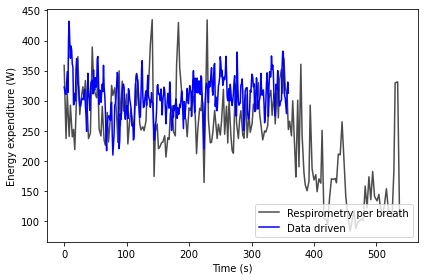

Subj  1  SS Condition  3
DD avg. estimate (W):  392.7 Metabolics (W):  387.56  Absolute Error (%):  1.33


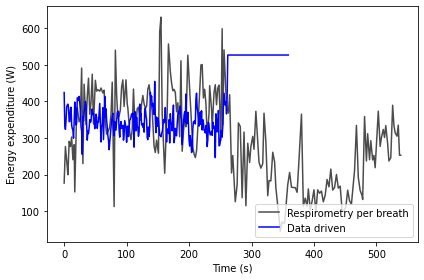

Subj  1  SS Condition  6
DD avg. estimate (W):  678.38 Metabolics (W):  637.11  Absolute Error (%):  6.48


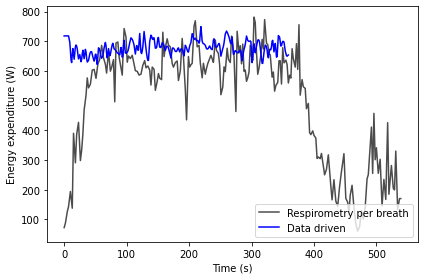

Subj  1  SS Condition  8
DD avg. estimate (W):  531.55 Metabolics (W):  441.77  Absolute Error (%):  20.32


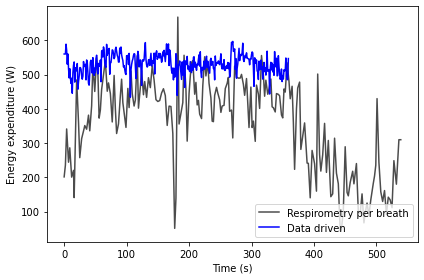

Subj  1  SS Condition  9
DD avg. estimate (W):  633.84 Metabolics (W):  618.92  Absolute Error (%):  2.41


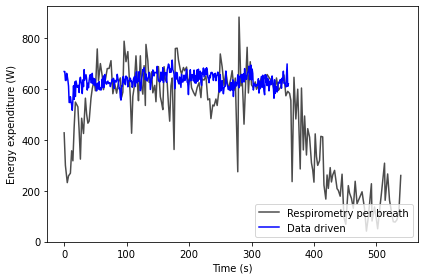

Absolute error (%) for this subject across conditions:  8.23
Subj  2  SS Condition  1
Subj  2  SS Condition  2
DD avg. estimate (W):  204.42 Metabolics (W):  224.03  Absolute Error (%):  8.75


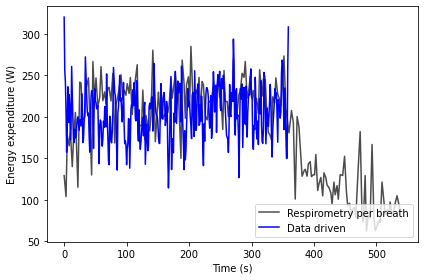

Subj  2  SS Condition  3
DD avg. estimate (W):  239.79 Metabolics (W):  325.33  Absolute Error (%):  26.29


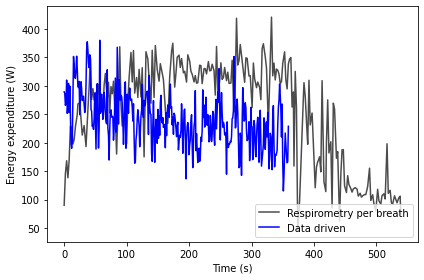

Subj  2  SS Condition  6
DD avg. estimate (W):  512.08 Metabolics (W):  513.31  Absolute Error (%):  0.24


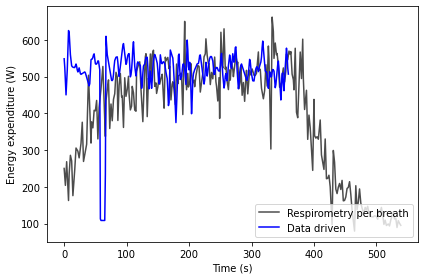

Subj  2  SS Condition  8
DD avg. estimate (W):  356.24 Metabolics (W):  338.55  Absolute Error (%):  5.23


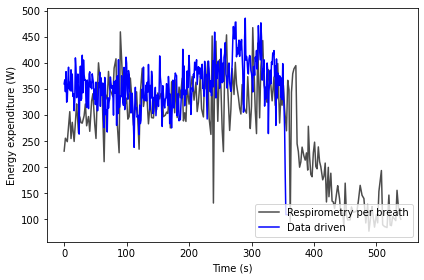

Subj  2  SS Condition  9
DD avg. estimate (W):  461.94 Metabolics (W):  513.19  Absolute Error (%):  9.99


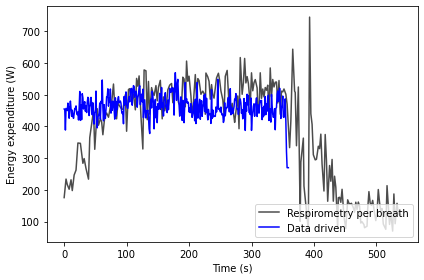

Absolute error (%) for this subject across conditions:  10.1
Subj  3  SS Condition  1
Subj  3  SS Condition  2
DD avg. estimate (W):  267.38 Metabolics (W):  245.87  Absolute Error (%):  8.75


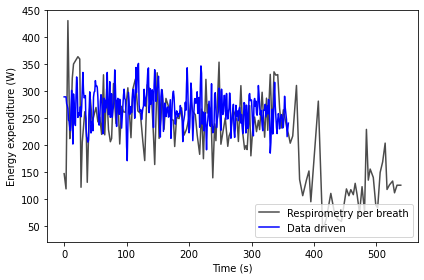

Subj  3  SS Condition  3
DD avg. estimate (W):  231.34 Metabolics (W):  353.97  Absolute Error (%):  34.65


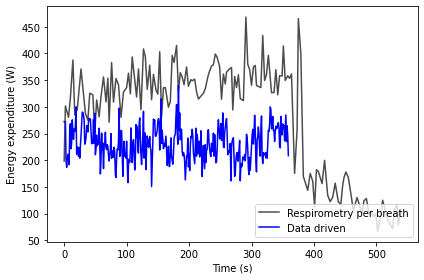

Subj  3  SS Condition  4
DD avg. estimate (W):  612.91 Metabolics (W):  766.72  Absolute Error (%):  20.06


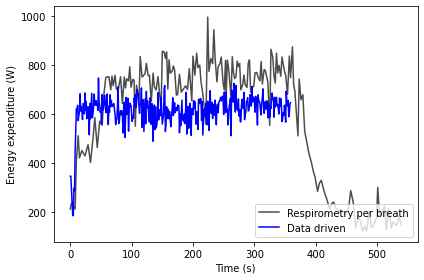

Subj  3  SS Condition  5
DD avg. estimate (W):  790.08 Metabolics (W):  870.7  Absolute Error (%):  9.26


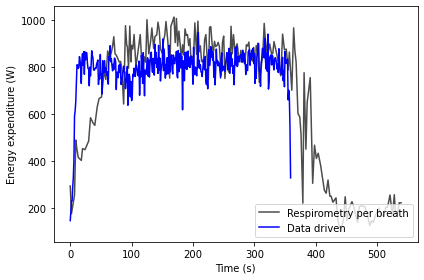

Subj  3  SS Condition  6
DD avg. estimate (W):  675.0 Metabolics (W):  707.28  Absolute Error (%):  4.56


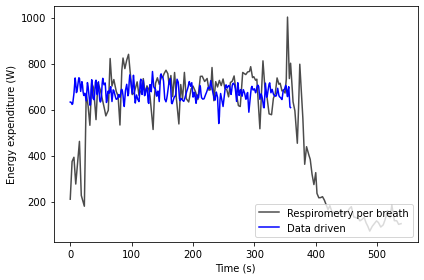

Subj  3  SS Condition  7
DD avg. estimate (W):  844.26 Metabolics (W):  838.8  Absolute Error (%):  0.65


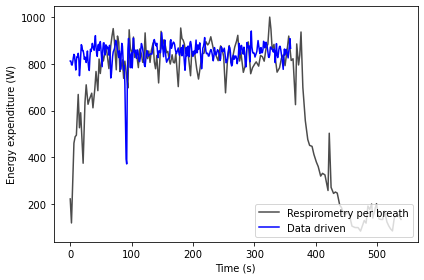

Subj  3  SS Condition  8
DD avg. estimate (W):  378.76 Metabolics (W):  342.71  Absolute Error (%):  10.52


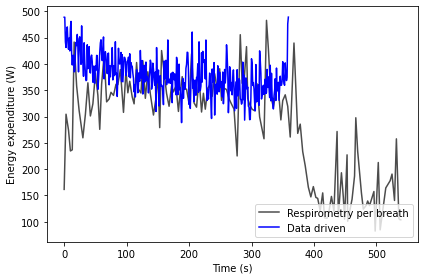

Subj  3  SS Condition  9
DD avg. estimate (W):  475.63 Metabolics (W):  481.13  Absolute Error (%):  1.14


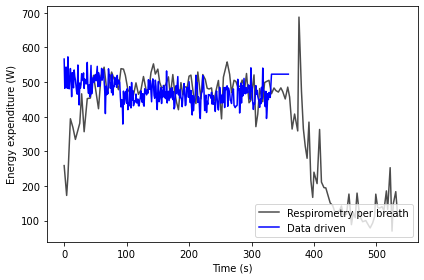

Absolute error (%) for this subject across conditions:  11.2
Subj  4  SS Condition  1
Subj  4  SS Condition  2
DD avg. estimate (W):  299.82 Metabolics (W):  293.15  Absolute Error (%):  2.27


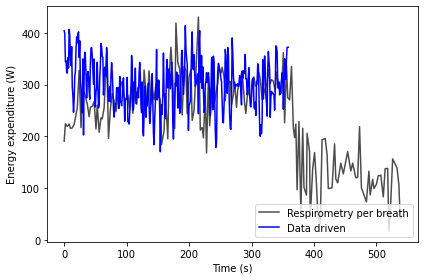

Subj  4  SS Condition  3
DD avg. estimate (W):  322.34 Metabolics (W):  423.49  Absolute Error (%):  23.88


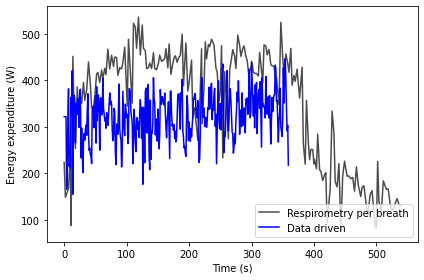

Subj  4  SS Condition  6
DD avg. estimate (W):  659.59 Metabolics (W):  655.01  Absolute Error (%):  0.7


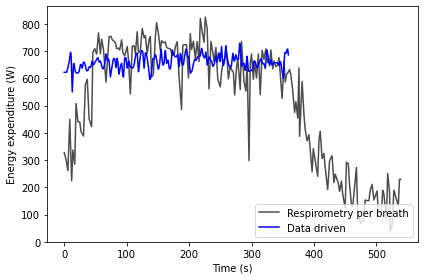

Subj  4  SS Condition  7
DD avg. estimate (W):  771.22 Metabolics (W):  741.52  Absolute Error (%):  4.0


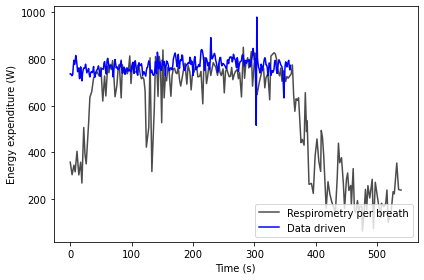

Subj  4  SS Condition  8
DD avg. estimate (W):  630.88 Metabolics (W):  610.18  Absolute Error (%):  3.39


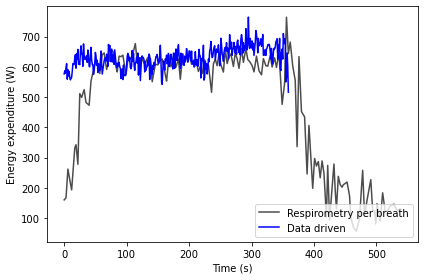

Subj  4  SS Condition  9
DD avg. estimate (W):  519.43 Metabolics (W):  415.01  Absolute Error (%):  25.16


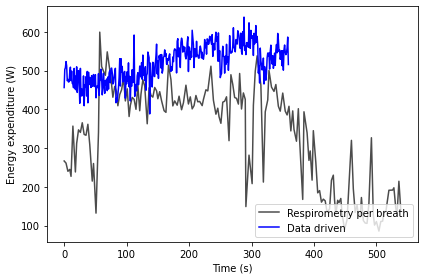

Absolute error (%) for this subject across conditions:  9.9
Subj  5  SS Condition  1
Subj  5  SS Condition  2
DD avg. estimate (W):  276.24 Metabolics (W):  231.78  Absolute Error (%):  19.18


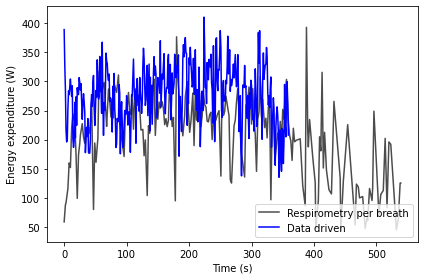

Subj  5  SS Condition  3
DD avg. estimate (W):  407.1 Metabolics (W):  310.22  Absolute Error (%):  31.23


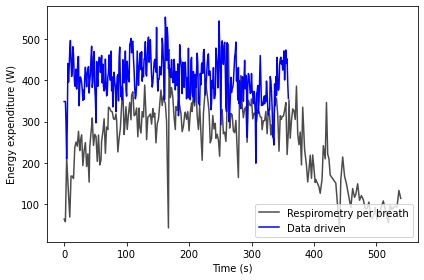

Subj  5  SS Condition  8
DD avg. estimate (W):  414.15 Metabolics (W):  358.93  Absolute Error (%):  15.38


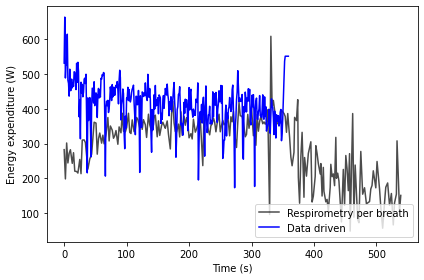

Subj  5  SS Condition  9
DD avg. estimate (W):  394.53 Metabolics (W):  475.59  Absolute Error (%):  17.04


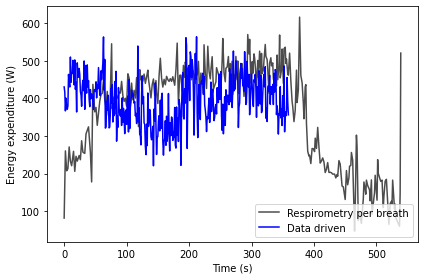

Absolute error (%) for this subject across conditions:  20.71
Average absolute error (%) across all subjects and conditions: 11.55


In [3]:
# loop through, to load subj-cond pairs and compute data-driven estimates and compare to metabolics
ss_dd_time_offset = [0, -1, 0, -3, 0, 0, 0, -8, 19, 20, 19, 19, 16, -16, 0, 0, 0, 0, -4, -42,-42,0,0,-12] # time offsets for each subject between metabolics computer and raspberry pi
t_mat = []
met_mat = []
dd_lists = []
dd_t_lists = []
dd_lists_tv = []
dd_t_lists_tv = []
met_lists_tv = []
met_t_lists_tv = []
basal_rate_list = []
subj_errs = np.zeros(len(subjects))
subj_errs_cnt = np.zeros(len(subjects))
skip_subjects=0
for i, subj in enumerate(subjects[skip_subjects:]):
    i= i+skip_subjects
    subj_abs_err = []
    metabolics, _, met_2mins, _, met_int_mat, start_stamps, t_mat_temp, met_mat_temp,_ = dw.calc_metabolics2(real_time_est, subj, visualize, add_hr, num_met_conds, cum_time_s)

    # load raw metabolics data
    met_raw_mat, ts_vec = dw.loadRawMet(real_time_est, subj, timezone)
    met_ss_interp[i,:] = metabolics[:5,0]
    t_mat.append(t_mat_temp)
    met_mat.append(met_mat_temp)
    stand_est[0,i] = metabolics[0,0]
    metabolics_real[i, :] = metabolics[stand_offset:,0]
    met_2min_est[i,:] = met_2mins[stand_offset:]
    met_int[i,:,:] = met_int_mat[stand_offset:,:]
    subj_start = timezone.localize(start_stamps[0])
    subj_stop = timezone.localize(max(start_stamps) + datetime.timedelta(seconds=cum_time_s + 5))

    # load basal rate for dd-estimates
    basal_rate = np.loadtxt(real_time_est + subj + '\\basal_rate.txt')
    basal_rate_list.append(basal_rate)

    cond_cnt = -1
    for j, cond in enumerate(ss_conditions):
        if cond in os.listdir(real_time_est+subj):# check if it exists in the folder
            true_inds[j,i] = 1
            cond_cnt += 1
            print('Subj ', i+1,' SS Condition ', j+1)
            loc_cond_timestamp = timezone.localize(start_stamps[cond_cnt]) # time stamp to align data
            if j == 0: # skip standing condition
                pass
            else:
                # load the estimates and timestamps from the DD model, interpolate
                subj_cond_dir = real_time_est + subj + '\\' + cond + '\\'
                data_files = os.listdir(subj_cond_dir)
                data_files = natsorted(data_files)
                if (estimate_file_name not in data_files) or overwrite_estimates: # first process the raw data into estimates
                    dw.computeEstimatesFromIMU(real_time_est, subj, cond, timezone, estimate_file_name, masses[i], heights[i], shift_ind, stride_detect_window, detect_window, peak_height_thresh, peak_min_dist, shank_gyro_z_ind, b, a, deg2rad, model_weights, basal_rate, 5.0, save_bin_data, metabolics[j,0], overwrite_estimates)
                dd_temp, subjcond_est, subjcond_time = dw.computeDDinter(real_time_est, est_col_ind, subj, cond, subj_cond_dir, estimate_file_name, timezone, loc_cond_timestamp+datetime.timedelta(seconds=ss_dd_time_offset[i]), cond_time_s)
                dd_int[i,j-1,:] = dd_temp
                print('DD avg. estimate (W): ',round(np.mean(dd_temp),2), 'Metabolics (W): ', round(metabolics_real[i, j-1],2),' Absolute Error (%): ', round(100*abs(np.mean(dd_temp) - metabolics_real[i, j-1])/metabolics_real[i, j-1],2))
                subj_abs_err.append(abs(np.mean(dd_temp) - metabolics_real[i, j-1])/metabolics_real[i, j-1])
                dd_lists.append(subjcond_est)
                dd_t_lists.append(subjcond_time)

                if visualize:
                    dw.watchValidationPlot(np.zeros(len(met_int[i,j-1,:])), np.zeros(len(met_int[i,j-1,:])), met_int[i,j-1,:], np.zeros(len(met_int[i,j-1,:])), dd_int[i,j-1,:])
        else:
            subj_abs_err.append(-1)
            dd_lists.append([-1])
            dd_t_lists.append([-1])
    ss_mean = []
    for l in subj_abs_err:
        if l != -1:
            ss_mean.append(l)
    print("Absolute error (%) for this subject across conditions: ", round(np.mean(ss_mean)*100.0,2))
    subj_errs[i] = np.mean(ss_mean)
    subj_errs_cnt[i] = len(ss_mean)

print("Average absolute error (%) across all subjects and conditions:", np.round(np.sum(subj_errs*subj_errs_cnt)/np.sum(subj_errs_cnt)*100,2))

np.save(results_dir+'true_inds',true_inds)
np.save(results_dir+'met_int.npy', met_int)
np.save(results_dir+'dd_int.npy', dd_int)
np.save(results_dir+'dd_lists.npy',dd_lists)
np.save(results_dir+'dd_t_lists.npy',dd_t_lists)
np.save(results_dir+'met_real.npy', metabolics_real)   
np.save(results_dir+'met_2min_est.npy', met_2min_est)